In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import bioframe
import numpy as np
import seaborn as sns
from pybedtools import BedTool
import re

In [2]:
gm_df = pd.read_csv('../annotations/GM12878_hg38_50kb.tsv', sep = '\t')
gm_df.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,chr1,50000,100000,0.047586,0.010207,0.076204,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,chr1,100000,150000,0.050368,0.015204,0.093003,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,chr1,150000,200000,0.059842,0.013402,0.087317,NaN,0.486340,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,chr1,200000,250000,NaN,0.000232,0.011488,NaN,0.480564,NaN,NaN,NaN,NaN,NaN,NaN,0.0


# GC content and E1

In [3]:
masked_track = gm_df[~gm_df['E1'].isna()]

In [4]:
def get_state_values(hmm_track, hmm, signal,  states = False, clip = False):
    if not states:
        states = hmm_track[hmm].unique()
        states.sort()
    l = []
    for state in states:
        vals = hmm_track[hmm_track[hmm] == state][signal].values
        if clip:
            vals = np.clip(vals, np.percentile(vals, 1), np.percentile(vals, 99))
        l.append(vals)
    return l

In [5]:
gc_states = get_state_values(masked_track, 'HMM3P','GC')

In [6]:
labels=['B', 'Mbb', 'M', 'Maa', 'A']

Text(0.5, 1.0, 'GC coverage')

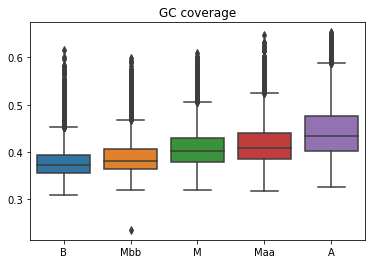

In [7]:
sns.boxplot(data=gc_states)
plt.gca().set_xticklabels(labels);
plt.title('GC coverage')

In [8]:
E1_states = get_state_values(masked_track, 'HMM3P','E1')

Text(0.5, 1.0, 'E1 coverage')

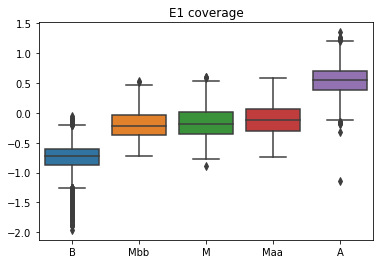

In [26]:
sns.boxplot(data=E1_states)
plt.gca().set_xticklabels(labels);
plt.title('E1 coverage')

# Gene expression

In [10]:
gencode = pd.read_csv('../data/gencode.v37.annotation.gff3.gz',
               names=['chrom','annot','type','start','stop','na1','strand','na2','genestuff'],
                      delimiter='\t',skiprows=7)

genes = gencode.loc[gencode['type'].values=='gene']
genes.rename(columns={'stop':'end'}, inplace=True)
genes = genes.astype({'start':int,'end':int})
### need to join gene table & expression table
geneNames =  genes['genestuff'].str.split(';')
genes['Description'] = [i[3].split('=')[1] for i in geneNames]
genes['Name'] = [i[0].split('=')[1] for i in geneNames]
genes.head()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,chrom,annot,type,start,end,na1,strand,na2,genestuff,Description,Name
0,chr1,HAVANA,gene,11869,14409,.,+,.,ID=ENSG00000223972.5;gene_id=ENSG00000223972.5...,DDX11L1,ENSG00000223972.5
12,chr1,HAVANA,gene,14404,29570,.,-,.,ID=ENSG00000227232.5;gene_id=ENSG00000227232.5...,WASH7P,ENSG00000227232.5
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,ID=ENSG00000278267.1;gene_id=ENSG00000278267.1...,MIR6859-1,ENSG00000278267.1
28,chr1,HAVANA,gene,29554,31109,.,+,.,ID=ENSG00000243485.5;gene_id=ENSG00000243485.5...,MIR1302-2HG,ENSG00000243485.5
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,ID=ENSG00000284332.1;gene_id=ENSG00000284332.1...,MIR1302-2,ENSG00000284332.1


In [11]:
expression = pd.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
               ,delimiter='\t', skiprows = 2)
expression.head()

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743
2,ENSG00000278267.1,MIR6859-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000243485.5,MIR1302-2HG,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.054223,0.00000,0.00000,0.00000,0.00000
4,ENSG00000237613.2,FAM138A,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000


In [12]:
t = expression.set_index('Name').join(genes.set_index('Name'),rsuffix='_')

In [13]:
expressed_genes = t.copy()
expressed_genes.reset_index(inplace=True)
expressed_genes = expressed_genes[['chrom','start','end','strand','Cells - EBV-transformed lymphocytes']]
expressed_genes = expressed_genes.iloc[~pd.isnull(expressed_genes['chrom'].values)]
expressed_genes.sort_values(['chrom','start','end'],inplace=True)
expressed_genes['start'] = expressed_genes['start'].values.astype(int) #since just using .astype() method wasn't working..
expressed_genes['end'] = expressed_genes['end'].values.astype(int)
expressed_genes = expressed_genes[expressed_genes['chrom'].isin(gm_df.chrom.unique())] #Filters out chroms not available in Hi-C HMM

In [14]:
expressed_genes

,chrom,start,end,strand,Cells - EBV-transformed lymphocytes
0,chr1,11869,14409,+,0.000000
1,chr1,14404,29570,-,2.494770
2,chr1,17369,17436,-,0.000000
3,chr1,29554,31109,+,0.000000
4,chr1,34554,36081,-,0.000000
...,...,...,...,...,...
27188,chr9,138150075,138177433,+,0.102107
27189,chr9,138177426,138179774,-,0.000000
27190,chr9,138199933,138203325,-,0.000000
27192,chr9,138259595,138259698,+,0.000000


In [15]:
from bioframe.util import bedtools
def bedtools_intersect_basePairs(left, right, rsuffix='_', **kwargs):
    """
    >>> ixn = bedtools_intersect(bed1, bed2, wao=True), needed to delete other keys b/c they clashed
   """
    
    out = bedtools.intersect(a=left, b=right,wao=True)
    out.columns = list(left.columns) + [c+rsuffix if c in left.columns else c for c in right.columns] + ['bpOverlap']
    return out

In [18]:
gm_df

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,chr1,50000,100000,0.047586,0.010207,0.076204,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,chr1,100000,150000,0.050368,0.015204,0.093003,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,chr1,150000,200000,0.059842,0.013402,0.087317,NaN,0.486340,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,chr1,200000,250000,NaN,0.000232,0.011488,NaN,0.480564,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57504,chr22,50600000,50650000,1.057163,2.498999,1.018248,0.002487,0.528300,0.164303,0.361200,-0.089582,True,1.0,1.0,2.0
57505,chr22,50650000,50700000,0.835666,1.842913,0.874425,0.003011,0.514480,-0.145054,0.425879,0.146270,False,0.0,1.0,2.0
57506,chr22,50700000,50750000,0.918220,1.939161,0.896969,0.002781,0.566380,-0.289178,0.559216,0.411856,False,0.0,1.0,2.0
57507,chr22,50750000,50800000,0.394678,0.743036,0.555233,0.005469,0.441900,-0.097439,0.437074,0.181019,False,0.0,1.0,2.0


In [19]:
intersection = bedtools_intersect_basePairs(gm_df, expressed_genes)

In [20]:
intersection.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,...,binary,HMM2,HMM3,HMM3P,chrom_,start_,end_,strand,Cells - EBV-transformed lymphocytes,bpOverlap
0,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.48425,NaN,NaN,...,NaN,NaN,NaN,0.0,chr1,11869,14409,+,0.00000,2540
1,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.48425,NaN,NaN,...,NaN,NaN,NaN,0.0,chr1,17369,17436,-,0.00000,67
2,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.48425,NaN,NaN,...,NaN,NaN,NaN,0.0,chr1,29554,31109,+,0.00000,1555
3,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.48425,NaN,NaN,...,NaN,NaN,NaN,0.0,chr1,34554,36081,-,0.00000,1527
4,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.48425,NaN,NaN,...,NaN,NaN,NaN,0.0,chr1,14404,29570,-,2.49477,15166


In [21]:
mask = (intersection['E1'] == intersection['E1']) & (intersection['Cells - EBV-transformed lymphocytes']>0)

In [22]:
data = []
for i in range(5):
    track = intersection[(mask)&(intersection["HMM3P"]==i)]['Cells - EBV-transformed lymphocytes'].values
    data.append(np.log(track))

Text(0, 0.5, 'log(Expression level)')

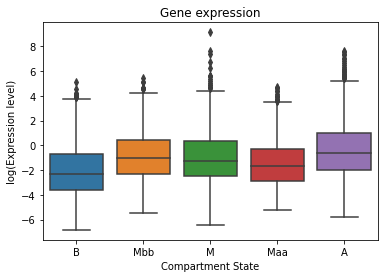

In [25]:
sns.boxplot(data=data)
plt.gca().set_xticklabels(labels);
plt.title('Gene expression')
plt.xlabel('Compartment State')
plt.ylabel('log(Expression level)')